In [1]:
import pandas as pd
import numpy as np
import json

data = [json.loads(line) for line in 
        open('/home/left/Desktop/dataMining/set2/ask2/yelp_academic_dataset_business.json', 'r')]

In [2]:
data = [x for x in data if x['city']=='Toronto']
data = np.array(data) # Convert list to numpy array

# Create an array with business with more than 15 reviews
business_col = np.array([])
for i in range(len(data)):
    if data[i]['review_count']>=15:
        business_col = np.append(business_col,data[i]['business_id'])

In [3]:
def get_business_index(business_id):
    return np.where( business_col == business_id)

In [4]:
user_business = []

with open('/home/left/Desktop/dataMining/set2/ask2/yelp_academic_dataset_review.json') as reviews_file:

    for line in reviews_file:
        line = json.loads(line)
        ind = get_business_index(line['business_id'])

        if ind[0].size>0:
            user_business.append([line['user_id'],line['business_id'], line['stars']])


In [32]:
user_business_array = np.array(user_business)
users = user_business_array[:,0]

unique_users, counts = np.unique(users, return_counts=True)
uniq_users = []

for i in range(len(unique_users)):
    if counts[i]>=15:
        uniq_users.append(unique_users[i])

businesses = user_business_array[:,1]
unique_businesses = np.unique(businesses)

unique_rows = np.unique(user_business_array, axis=0)
uniq_users = np.array(uniq_users)


# Create the sparse_array
sparse = np.zeros((len(unique_businesses), len(uniq_users)))
for i in range(len(unique_businesses)):
    user_index = np.where(unique_businesses[i] == unique_rows)[0]

    for j in range(len(user_index)):
        unique_user_ind = np.where(unique_rows[user_index[j]][0] == uniq_users) 
        if unique_user_ind[0].size>0:
            sparse[i][unique_user_ind[0][0]] = int(float(unique_rows[user_index[j]][2]))

In [33]:
stop=0
while(stop==0):
    # prune the rows(businesses with below 15 reviews)
    index_to_delete = []
    for i in range(sparse.shape[0]):
        nonzero_indexes = np.nonzero(sparse[i])
        if len(nonzero_indexes[0])<15:
            index_to_delete.append(i)
            
    #make new sparse array with deleted items and unique_businesses to track ids
    unique_businesses = np.delete(unique_businesses, index_to_delete)
    sparse = np.delete(sparse, index_to_delete, axis=0)
    
    #prune the columns(users)
    transposed_sparse = np.transpose(sparse)
    columns_to_delete = []
    for i in range(transposed_sparse.shape[0]):
        nonzero_values = np.nonzero(transposed_sparse[i])
        if len(nonzero_values[0])<15:
            columns_to_delete.append(i)
            
    #make new sparse array with deleted items and uniq_users to track ids
    uniq_users = np.delete(uniq_users, columns_to_delete)
    sparse = np.delete(sparse, columns_to_delete, axis=1)

    # If nothing to delete -> stop
    if len(index_to_delete)==0 and len(columns_to_delete)==0:
        stop=1

In [46]:
# Create the new data
data_csv = []
for i in range(sparse.shape[1]):
    for j in range(sparse.shape[0]):
        if sparse[j][i]>0:
            data_csv.append([uniq_users[i],unique_businesses[j], sparse[j][i]])
data_csv = np.array(data_csv)

In [47]:
# Load the correct file
table_R = pd.read_csv("pruned_data.csv", header = None)
table_R = table_R.to_numpy()

In [48]:
from operator import itemgetter
data_csv = sorted(data_csv, key=itemgetter(0,1), reverse=True)
table_R = sorted(table_R, key=itemgetter(0,1), reverse=True)

# Βημα 2

In [1]:
import pandas as pd 
import math
import numpy as np
import json

table_R = pd.read_csv("pruned_data.csv", header = None)
new_header = ['user_id', 'business_id', 'rating']
table_R.columns = new_header[:]
print(table_R)

                       user_id             business_id  rating
0       TZQSUDDcA4ek5gBd6BzcjA  qUWqjjjfpB2-4P3He5rsKw     4.0
1       TZQSUDDcA4ek5gBd6BzcjA  6n_MDeYxU1ihB38be9TkVA     4.0
2       TZQSUDDcA4ek5gBd6BzcjA  jo4KmAqlZ7vxjHIP7IIkAw     5.0
3       TZQSUDDcA4ek5gBd6BzcjA  dsAcgF6qtZy2m6d_yWCrGQ     4.0
4       TZQSUDDcA4ek5gBd6BzcjA  siaRCT2-PkyeXUVKrywcTg     4.0
...                        ...                     ...     ...
197107  3L3CI2Om_2SE3T6hxrJKPQ  j_hB9Gt3VMJAbA2JyvyFjw     4.0
197108  3L3CI2Om_2SE3T6hxrJKPQ  WKcVegcUjAld1S737a_QHw     4.0
197109  3L3CI2Om_2SE3T6hxrJKPQ  1FL3oE2mqq_EFAYPd1TWUg     5.0
197110  3L3CI2Om_2SE3T6hxrJKPQ  hlrZHM4D48XiQtXh6cRg_w     1.0
197111  3L3CI2Om_2SE3T6hxrJKPQ  _cVCzKQGt23KKW1M07Yvkw     5.0

[197112 rows x 3 columns]


In [2]:
print("Sample data should have {} rows \n".format(math.ceil(len(table_R)*0.05)))
sample_data = table_R.sample(frac=0.05)
print(len(sample_data))

Sample data should have 9856 rows 

9856


In [3]:
# Setting sample ratings to zero
for index in sample_data.index:
    table_R.at[index, 'rating'] = 0

In [4]:
tableR = table_R.to_numpy()
unique_users = np.unique(tableR[:,0])
unique_business = np.unique(tableR[:,1])

In [5]:
sparse_array = np.zeros((len(unique_users), len(unique_business)))
# Create the sparse_array
for i in range(len(unique_users)):
    business_index = np.where( unique_users[i] == table_R['user_id'])
    
    for j in range(len(business_index[0])):
        temp_business = table_R['business_id'][business_index[0][j]] #take business_id for given index
        unique_business_ind = np.where(temp_business == unique_business)
        sparse_array[i][unique_business_ind[0][0]] = table_R['rating'][business_index[0][j]]

# Βημα 3

### Get user similarities table

In [6]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(sparse_array)
sample_array = sample_data.to_numpy()

### This is helping functions to get user_id or business_id index in unique_users/business array

In [7]:
def find_index(user_id):
    ind = np.where(user_id  == unique_users)
    return ind[0][0]
def find_business(business_id):
    ind = np.where(business_id == unique_business)
    return ind[0][0]

### UCF prediction function

In [8]:
def UCF_prediction(user1, common_users, ratings, k_values):
    #k_values = [1,5,10,20,50,100,200,500,1000]
    user_ind1 = find_index(user1)
    similar = []
    predictions_k = []
    # For every common user find his similarity to our user
    for i in range(len(common_users)):
        temp_ind = find_index(common_users[i])
        similar.append([common_users[i], float(similarities[user_ind1][temp_ind]), int(ratings[i])])
    
    # Sort similarities and take k most similar to our user
    from operator import itemgetter
    vectors = np.array(sorted(similar, key=itemgetter(1), reverse=True))
    
    # For every given k calculate the predictions for the given user
    for k in range(len(k_values)):
        temp_vectors = vectors[:k_values[k]]
        
        similarity_vector = temp_vectors[:,1].astype(float)
        ratings_vector = temp_vectors[:,2].astype(int)

        # Calculate prediction
        numerator = 0
        denominator = np.sum(similarity_vector)
        for i in range(len(similarity_vector)):
            numerator += similarity_vector[i]*ratings_vector[i]
        predictions_k.append(numerator/denominator)
        
    # Return a list with predictions for the user for every k value
    return predictions_k

### Prepare the data and execute UCF_prediction for every given k

In [9]:
predictions = []
business_avg_pred = []
k_values = [1,5,10,20,50,100,200,500,1000]
#k_values = []
for i in range(sample_array.shape[0]): # For every pair (u,b) that have missing rating
    common_users = []
    common_ratings = []
    business_index = find_business(sample_array[i][1]) # Get business index
    common_users_indexes = np.nonzero(sparse_array[:,business_index]) # FIND INDEXES FOR NONZERO VALUES ONLY!
    for j in range(len(common_users_indexes[0])): # For every row in spars- (Actually for every user)
        common_ratings.append(sparse_array[common_users_indexes[0][j]][business_index]) # Append ratings
        common_users.append(unique_users[common_users_indexes[0][j]]) # Append the user_id
    
    # Append the prediction
    predictions.append(UCF_prediction(sample_array[i][0], common_users, common_ratings, k_values))
    business_avg_pred.append(sum(common_ratings)/len(common_ratings))
    
ucf_predictions = np.array(predictions)

# Βημα 4

In [10]:
# Get transposed sparse array and similiarities between businesses
transposed_sparse = np.transpose(sparse_array)
business_similarities = cosine_similarity(transposed_sparse)

In [11]:
def ICF_prediction(business1, common_businesses, ratings, k_values):
    #k_values = [1,5,10,20,40,50,60,70,80,100]
    business_ind1 = find_business(business1)
    similar = []
    predictions_k = []
    
    # For every common business find its' similarity to our business
    for i in range(len(common_businesses)):
        temp_ind = find_business(common_businesses[i])
        similar.append([common_businesses[i], float(business_similarities[business_ind1][temp_ind]), int(ratings[i])])
    
    # Sort similarities and take k most similar to our business
    from operator import itemgetter
    vectors = np.array(sorted(similar, key=itemgetter(1), reverse=True))
    
    # For every given k calculate the predictions for the given user
    for k in range(len(k_values)):
        temp_vectors = vectors[:k_values[k]]
        
        similarity_vector = temp_vectors[:,1].astype(float)
        ratings_vector = temp_vectors[:,2].astype(int)

        # Calculate prediction
        numerator = 0
        denominator = np.sum(similarity_vector)
        for i in range(len(similarity_vector)):
            numerator += similarity_vector[i]*ratings_vector[i]
        predictions_k.append(numerator/denominator)
        
    # Return a list with predictions for the user for every k value
    return predictions_k

### Prepare the data and execute ICF_prediction for every given k

In [12]:
predictions = []
user_avg_pred = []
k_values = [1,5,10,20,40,50,60,70,80,100]
#k_values
for i in range(sample_array.shape[0]): # For every pair (u,b) that have missing rating
    common_ratings = []
    common_businesses = []
    user_index = find_index(sample_array[i][0]) # Get user index
    common_business_indexes = np.nonzero(sparse_array[user_index,:]) # FIND BUSINESSES INDEXES FOR NONZERO VALUES ONLY!

    for j in range(len(common_business_indexes[0])): # For every row in spars- (Actually for every rated business)
        common_ratings.append(transposed_sparse[common_business_indexes[0][j]][user_index]) # Append ratings
        common_businesses.append(unique_business[common_business_indexes[0][j]]) # Append the user_id
    # Append the prediction
    predictions.append(ICF_prediction(sample_array[i][1], common_businesses, common_ratings, k_values))

    user_avg_pred.append(sum(common_ratings)/len(common_ratings))
    
ifc_predictions = np.array(predictions)

# Βήμα 5

In [47]:
from numpy.linalg import svd 

u, s, vt = svd(sparse_array, full_matrices=False)
s = np.diag(s)

# keep the r largest singular vectors
r = 5
Rk_aprrox = u[:,:r] @ s[0:r, :r] @ vt[:r,:]

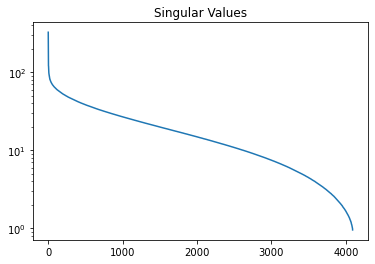

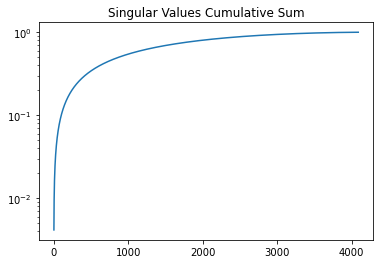

[[-0.00508805  0.00798275  0.03180521 ...  0.0211608   0.00602125
   0.05553681]
 [ 0.08397981  0.06109197  0.13084715 ...  0.33360421  0.14668214
   0.57123439]
 [ 0.00837869 -0.00123132  0.01286822 ...  0.00588874 -0.01460127
   0.03405225]
 ...
 [ 0.00627475  0.01098065  0.01381533 ...  0.03066783  0.02213099
   0.04531393]
 [ 0.02620984  0.0072356  -0.00413059 ...  0.01249215  0.00259576
  -0.00433172]
 [ 0.03099672  0.00733428 -0.0062688  ...  0.00329296 -0.00552166
  -0.03771329]]


In [48]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.semilogy(np.diag(s))
plt.title('Singular Values')
plt.show()

plt.figure(2)
plt.semilogy(np.cumsum(np.diag(s)/np.sum(np.diag(s))))
plt.title('Singular Values Cumulative Sum')
plt.show()

print(Rk_aprrox)

# Βήμα 6

In [13]:
RMSE_UCF = []
true_ratings = sample_data['rating'].to_numpy()

for i in range(ucf_predictions[0].size):
    predicted_ratings = np.array(ucf_predictions[:,i])
    sum_of_difference = 0
    for i in range(sample_data.shape[0]):
        sum_of_difference += (predicted_ratings[i] - true_ratings[i])**2
    RMSE_UCF.append(math.sqrt(sum_of_difference/sample_data.shape[0]))

In [14]:
RMSE_ICF = []
true_ratings = sample_data['rating'].to_numpy()

for i in range(ifc_predictions[0].size):
    predicted_ratings = np.array(ifc_predictions[:,i])
    sum_of_difference = 0
    for i in range(sample_data.shape[0]):
        sum_of_difference += (predicted_ratings[i] - true_ratings[i])**2
    RMSE_ICF.append(math.sqrt(sum_of_difference/sample_data.shape[0]))

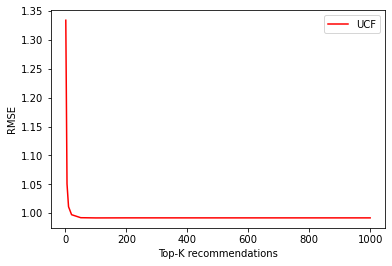

In [18]:
import matplotlib.pyplot as plt
x = [1,5,10,20,50,100,200,500,1000]
plt.plot(x, RMSE_UCF, "r", label = "UCF")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Top-K recommendations");

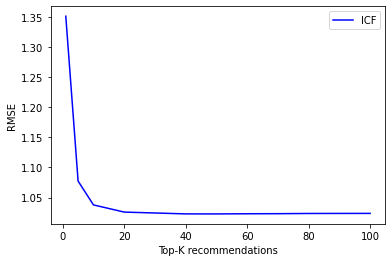

In [19]:
import matplotlib.pyplot as plt
x = [1,5,10,20,40,50,60,70,80,100]
plt.plot(x, RMSE_ICF, "b", label = "ICF")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Top-K recommendations");

In [16]:
RMSE_UCF

[1.333912381027982,
 1.050865684464112,
 1.011269079066268,
 0.9974360090416403,
 0.9922330640060986,
 0.9918579594451219,
 0.9919556605044251,
 0.99192326150088,
 0.9919278965310658]

In [17]:
RMSE_ICF

[1.3510307512818096,
 1.077426196547374,
 1.0378534601893692,
 1.0259383522125343,
 1.0229370092919066,
 1.0229010841152368,
 1.0231597469323792,
 1.0232852497897929,
 1.0236284332562577,
 1.0237711007883836]